In [1]:
import xarray as xr
import numpy as np
import xarray as xr
import dask
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pickle
import webdataset as wds
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader


# Prepare data
### 1 - Put data, mean, std and mask to a dictionnary 

In [5]:
def get_mask(data):
    """
        get edges mask
        data : batch, depth, x, y 
    """
    mask = np.zeros(data.shape[-2:], dtype=bool)
    
    for i in [0,-1]:
        mask[:13,i] = True
        mask[48:,i] = True
        mask[i,:]   = True
    return torch.from_numpy(np.expand_dims(np.expand_dims(mask, 0), 0))

def replaceEdges(data,mask,values=None):
    """
        Replace edges by a value. Default is nan
        data : batch, depth, x, y 
    """
    batch_size,depth = np.shape(data)[0:2]
    if values is None:
        mask = np.tile(mask, (batch_size, depth, 1, 1))
        data[mask] = np.nan
    else:
        mask = np.tile(mask, (batch_size, 1, 1))
        data = data.transpose(1, 0, 2, 3)
        values = np.squeeze(values)
        for i in range(len(values)):
            data[i][mask] = values[i]
        data = data.transpose(1, 0, 2, 3)
    return data

def get_standInfos(data,x_mean=None,x_std=None):
    """
        data : batch, depth, x, y 
    """
    if x_mean is None:
        # Get min, max value aming all elements for each column
        x_mean = np.nanmean(data, axis=(0,2,3), keepdims=True)
        x_std  = np.nanstd(data, axis=(0,2,3), keepdims=True)
        return x_mean, x_std
    else : 
        data = (data - x_mean)/ x_std
        return data

def info_toDico(mask,mean,std):
    return {"mask": mask[0],
            "mean": mean,
            "std": std}

def save_dico(dico,file,radical):
    file_name = f"{file}{radical}_info.pkl"
    with open(file_name, 'wb') as file:
        pickle.dump(dico, file)
    print("feature prepared and saved")

def get_info(dataset,file,radical):
    """
        dataset : batch, depth, x, y 
    """
    mask = get_mask(dataset)
    data = replaceEdges(dataset,mask)
    mean, std  = get_standInfos(data)
    dico = info_toDico(mask,mean,std)
    save_dico(dico,file,radical)
    np.save(f"/gpfswork/rech/omr/uen17sn/dataDiffModel/{radical}_data.npy",data)
    #return dico

def partition_file(file,radical):
    data = np.load(f'{file}/{radical}_data.npy')
    os.makedirs(f'{file}/partitions', exist_ok=True)
    num_partitions = data.shape[0]
    data_splitted  = np.array_split(data, num_partitions, axis=0)
    for i in range(num_partitions): 
        file_path = os.path.join(f'{file}/partitions', f'{i}.{radical}.npy')
        np.save(file_path, data_splitted[i])
        if i%500==0:
            print(f'Saved partition {i} at {file_path}')

In [3]:
path = "/gpfswork/rech/omr/udu91zn/diffusionmodels"

In [4]:
ssh = np.expand_dims(np.load(f'{path}/ssh.npy'),1)
get_info(ssh,"/gpfswork/rech/omr/uen17sn/dataDiffModel/","ssh")

feature prepared and saved


In [5]:
toce = np.load(f'{path}/toce.npy')
get_info(toce,"/gpfswork/rech/omr/uen17sn/dataDiffModel/","toce")

feature prepared and saved


In [4]:
soce = np.load(f'{path}/soce.npy')
get_info(soce,"/gpfswork/rech/omr/uen17sn/dataDiffModel/","soce")

feature prepared and saved


# Partition Files

In [6]:
partition_file("/gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw","ssh")
partition_file("/gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw","soce")
partition_file("/gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw","toce")

Saved partition 0 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/0.ssh.npy
Saved partition 500 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/500.ssh.npy
Saved partition 1000 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/1000.ssh.npy
Saved partition 1500 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/1500.ssh.npy
Saved partition 2000 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/2000.ssh.npy
Saved partition 2500 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/2500.ssh.npy
Saved partition 3000 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/3000.ssh.npy
Saved partition 3500 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/3500.ssh.npy
Saved partition 4000 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/4000.ssh.npy
Saved partition 4500 at /gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions/4500.ssh.npy
Saved partition 5000 at /gpfswork/rech

In [8]:
total = 0
for root, dirs, files in os.walk( "/gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/partitions"):
    for file in files:
        total += os.path.getsize(os.path.join(root, file))
size = total / (1024**3)
print("Volume total : {:.2f} Go".format(size))

Volume total : 35.25 Go


# DANS UTILS

In [10]:
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import webdataset as wds
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data.distributed import DistributedSampler
#from ipdb import set_trace

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, file,mu=None,std=None,mask=None):
        self.data_dir = file
        self.partition_files = os.listdir(self.data_dir)
        if mu is None:
            self.mu,self.std,self.mask = {},{},{}
            self.get_infos()
        else:
            self.mu   = mu
            self.std  = std
            self.mask = mask

    def __len__(self):
        return len(self.partition_files)//3

    def get_infos(self):
        for feature in ["soce","toce","ssh"]:
            file_path = f'/gpfswork/rech/omr/uen17sn/dataDiffModel/{feature}_info.pkl'
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                self.mu[feature]   = data["mean"]
                self.std[feature]  = data["std"]
                self.mask[feature] = data["mask"]
                
    def standardize_4D(self,sample,feature):
        """
            Standardize the data given a mean and a std
        """
        return (sample - self.mu[feature]) / self.std[feature]
    
    def replaceEdges(self,data,feature,values=None):
        """
            Replace edges by a values. Default is 0
            data : batch, depth, x, y 
        """
        batch_size,depth = np.shape(data)[0:2]
        if values is None:
            mask = np.tile(self.mask[feature], (batch_size, depth, 1, 1))
            data[mask] = 0
        else:
            mask = np.tile(self.mask[feature], (batch_size, 1, 1))
            data = data.transpose(1, 0, 2, 3)
            values = np.squeeze(values)
            for i in range(len(values)):
                data[i][mask] = values[i]
            data = data.transpose(1, 0, 2, 3)
        return data

    def padData(self,dataset,xup,xdown,yup,ydown,val):
        """
            pad data on axis x and y
        """
        return np.pad(dataset, ((0, 0), (0, 0), (yup, ydown), (xup, xdown)), mode='constant',constant_values=val)

                            
    def __getitem__(self, i):
        f    = self.partition_files[i]
        id_  = int(f.split('_')[1].split('.')[0])
        dico = {}
        for feature in ["soce","toce","ssh"]:
            data = np.load(os.path.join(self.data_dir, f'{feature}_{id_}.npy'))
            data = self.standardize_4D(data,feature)
            data = self.replaceEdges(data,feature)
            data = self.padData(data,1,1,4,5,0)
            dico[feature] = data
        return np.concatenate((dico['soce'], dico['toce'], dico['ssh']), axis=1).squeeze(axis=0)

In [ ]:
data_dir   = "/gpfswork/rech/omr/uen17sn/dataDiffModel/partitions"
dataset    = CreateDataset(data_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [18]:
batch = next(iter(dataloader))
np.shape(batch)

torch.Size([8, 71, 208, 64])

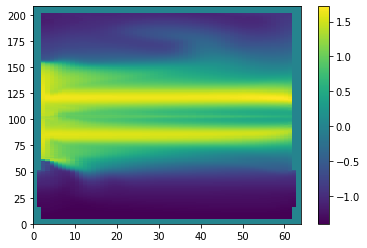

In [24]:
plt.pcolor(batch[0,0])
plt.colorbar()

### AUTRE

In [16]:
class TransformFields :

        def __init__(self, mu=None, std=None,mask=None) : 
            if mu is None:
                self.mu,self.std,self.mask = {},{},{}
                self.get_infos()
            else:
                self.mu   = mu
                self.std  = std
                self.mask = mask
        
        def __call__(self, sample) :
            dico = {}
            for feature in ["soce","toce","ssh"]:
                #1. standardize
                data = self.standardize_4D(sample,feature)
                #1. replace padding and edges by 0 
                data = self.replaceEdges(data,feature)
                dico[feature] = data
            #set_trace()
            data = np.concatenate((dico['soce'], dico['toce'], dico['ssh']), axis=1).squeeze(axis=0)
            return data


        def get_infos(self):
            for feature in ["soce","toce","ssh"]:
                file_path = f'/gpfswork/rech/omr/uen17sn/dataDiffModel/infos/{feature}_info.pkl'
                with open(file_path, 'rb') as file:
                    data = pickle.load(file)
                    self.mu[feature]   = data["mean"]
                    self.std[feature]  = data["std"]
                    self.mask[feature] = data["mask"]


        def standardize_4D(self,sample,feature):
            """
                Standardize the data given a mean and a std
            """
            return (sample[f'{feature}.npy'] - self.mu[feature]) / self.std[feature]

        def replaceEdges(self,data,feature,values=None):
            """
                Replace edges by a values. Default is 0
                data : batch, depth, x, y 
            """
            batch_size,depth = np.shape(data)[0:2]
            if values is None:
                mask = np.tile(self.mask[feature], (batch_size, depth, 1, 1))
                data[mask] = 0
            else:
                mask = np.tile(self.mask[feature], (batch_size, 1, 1))
                data = data.transpose(1, 0, 2, 3)
                values = np.squeeze(values)
                for i in range(len(values)):
                    data[i][mask] = values[i]
                data = data.transpose(1, 0, 2, 3)
            return data
                                        
                
def get_dataloader(tar_file, batch_size=5,num_workers=2,distributed=True) :
    composed = transforms.Compose([TransformFields()])
    dataset = wds.WebDataset(tar_file).shuffle(100).decode().map(composed) #nodesplitter=wds.split_by_worker

    #if distributed:
    #    torch.distributed.init_process_group(backend='gloo') 
    #    sampler = DistributedSampler(dataset)
    #else:
    #    sampler = None

    dl = DataLoader(dataset=dataset, batch_size=batch_size)#,num_workers=num_workers)#sampler=sampler
    return dl


In [18]:
loader = get_dataloader("/gpfswork/rech/omr/uen17sn/dataDiffModel/dataraw/dataset2.tar",8)

In [19]:
batch = next(iter(loader))

In [20]:
batch.shape

torch.Size([8, 71, 199, 62])

## ---

In [3]:
def load_dico(radical, file,i):
    """
        Load the dico containing:
            - padded data with raw values : (batch,depth,x,y)
            - mean :                        (1,depth,1,1)
            - std  :                        (1,depth,1,1) 
            - mask :                        (1,depht,x,y)
    """
    file = f'{file}{radical}{i}.pkl'
    with open(file, 'rb') as f:
        return pickle.load(f)

def standardize_4D(data,x_mean=None,x_std=None):
    """
        Standardize the data given a mean and a std
        OR
        Obtain mean and std of a dataset
            - data :         (batch,depth,x,y) 
            - mean and std : (1,depth,1,1)
    """
    if x_mean is None:
        # Get min, max value aming all elements for each column
        x_mean = np.nanmean(data, axis=(0,2,3), keepdims=True)
        x_std  = np.nanstd(data, axis=(0,2,3), keepdims=True)
        return x_mean, x_std
    else : 
        data = (data - x_mean)/ x_std
        return data

def replaceEdges(data,mask,values=None):
    """
        Replace edges by a values. Default is 0
        data : batch, depth, x, y 
    """
    batch_size,depth = np.shape(data)[0:2]
    if values is None:
        mask = np.tile(mask, (batch_size, depth, 1, 1))
        data[mask] = 0
    else:
        mask = np.tile(mask, (batch_size, 1, 1))
        data = data.transpose(1, 0, 2, 3)
        values = np.squeeze(values)
        for i in range(len(values)):
            data[i][mask] = values[i]
        data = data.transpose(1, 0, 2, 3)
    return data

def prepare_data(i,radical,file):
    """
        For a feature, standardize the data and replace mask by value 0
    """
    dico = load_dico(radical,file,i)
    stand_data  = standardize_4D(dico["data"],dico["mean"],dico["std"])
    #mean_stand, std_stand = standardize_4D(stand_data)
    masked_data = replaceEdges(stand_data,dico["mask"])#,mean_stand)
    del dico
    return masked_data

def load_dataset(i,file = "/home/tissot/data/",n=2):
    """
        Concatenate prepared channels, and select features
    """
    toce = prepare_data(i,"toce",file)[::n]
    print("toce prepared")
    soce = prepare_data(i,"soce",file)[::n]
    print("soce prepared")
    ssh = prepare_data(i,"ssh",file)[::n]
    print("ssh prepared")
    return np.concatenate((ssh,toce,soce),axis=1)

In [ ]:
def load_dico(radical, file):
    """
        Load the dico containing:
            - data with raw values : (batch,depth,x,y)
            - mean :                 (1,depth,1,1)
            - std  :                 (1,depth,1,1) 
            - mask :                 (1,depht,x,y)
    """
    file = f'{file}{radical}.pkl'
    with open(file, 'rb') as f:
        return pickle.load(f)
    
def padData(dataset,xup,xdown,yup,ydown,val):
    if len(np.shape(dataset))==3:
        return np.pad(dataset, ((0,0),(yup, ydown), (xup, xdown)), mode='constant',constant_values=np.nan)
    else:
        return np.pad(dataset, ((0,0),(0,0),(yup, ydown), (xup, xdown)), mode='constant',constant_values=np.nan)
        

def standardize_4D(data,x_mean=None,x_std=None):
    """
        Standardize the data given a mean and a std
        OR
        Obtain mean and std of a dataset
            - data :         (batch,depth,x,y) 
            - mean and std : (1,depth,1,1)
    """
    if x_mean is None:
        # Get min, max value aming all elements for each column
        x_mean = np.nanmean(data, axis=(0,2,3), keepdims=True)
        x_std  = np.nanstd(data, axis=(0,2,3), keepdims=True)
        return (data - x_mean)/ x_std
    else : 
        return (data - x_mean)/ x_std

def replaceEdges(data,mask,values=None):
    """
        Replace edges by a values. Default is 0
        data : batch, depth, x, y 
    """
    batch_size,depth = np.shape(data)[0:2]
    if values is None:
        mask = np.tile(mask, (batch_size, depth, 1, 1))
        data[mask] = 0
    else:
        mask = np.tile(mask, (batch_size, 1, 1))
        data = data.transpose(1, 0, 2, 3)
        values = np.squeeze(values)
        for i in range(len(values)):
            data[i][mask] = values[i]
        data = data.transpose(1, 0, 2, 3)
    return data

def prepare_data(radical,file):
    """
        For a feature, standardize the data and replace mask by value 0
    """
    dico = load_dico(radical,file)
    padded_mask = padData(dico["data"],xup=1,xdown=1,yup=5,ydown=4,val=0)
    padded_data = padData(dico["mask"],xup=1,xdown=1,yup=5,ydown=4,val=0)
    stand_data  = standardize_4D(padded_data,dico["mean"],dico["std"])
    masked_data = replaceEdges(stand_data,padded_mask)
    del dico
    return masked_data

"""
def load_dataset(i,file = "/home/tissot/data/",n=2):
    toce = prepare_data(i,"toce",file)[::n]
    print("toce prepared")
    soce = prepare_data(i,"soce",file)[::n]
    print("soce prepared")
    ssh = prepare_data(i,"ssh",file)[::n]
    print("ssh prepared")
    return np.concatenate((ssh,toce,soce),axis=1)
""";